In [60]:
from scipy import stats, special, interpolate
import numpy as np
from pathlib import Path
import h5py
import matplotlib.pyplot as plt
import seaborn as sns
import awkward as ak
import pandas as pd
import math
from sklearn import metrics
from damselfly.data import loaders

def background_cdf(x, N, var):
    return (1 - np.exp( - 1 * (x ** 2) / var)) ** (N)

def background_cdf_awk(x, n_signal, n_sample, var):
    
    N = n_sample - ak.to_numpy(n_signal)
    
    return (1 - np.exp( - 1 * (x ** 2) / var)) ** (N[:, np.newaxis])

def rician_pdf(x, var, loc_val):
    
    x = x[np.newaxis, :]
    loc_val = loc_val[:, np.newaxis]
    
    return x * np.exp( -1 * (x ** 2 + loc_val ** 2) / var ) * special.iv(0, x * 2 * loc_val / var)

def cdf_from_pdf(x, pdf):
    
    cdf = np.zeros((pdf.shape[0], x.size))
    for i in range(x.size):
        
        cdf[:, i] = np.trapz(pdf[:, 0:i+1], x[0:i+1], axis=-1)
        
    return cdf

def combine_batch_cdf(cdf, counts):
    
    count = 0
    cdf_ak = []
    for n in counts:
        cdf_ak.append(cdf[count:count+n, :])
        count+=n
    cdf_ak = ak.Array(cdf_ak)
        
    return ak.to_numpy(ak.prod(cdf_ak, axis=1))

def get_spectra_peaks(freq_spectra, threshold):
    
    peaks = []
    for i in range(freq_spectra.shape[0]):
        i_peak_inds = np.where(abs(freq_spectra[i, :]) > threshold)[0]
        i_peaks = abs(freq_spectra[i, i_peak_inds])

        peaks.append(list(i_peaks))
    
    return ak.Array(peaks)
    
def generate_signal_cdf(peaks, x, var, n_sample, batchsize=1000):
    
    peak_counts = ak.num(peaks, axis=1)
    num_spectra = ak.num(peaks, axis=0)
    
    spectra_inds = np.arange(0, num_spectra, 1)
    combined_cdf = np.zeros((num_spectra, x.size))
    
    for i, spectra_batch in enumerate(np.array_split(spectra_inds, num_spectra//batchsize)):
        
        batch_peaks = peaks[spectra_batch]
        batch_counts = ak.num(batch_peaks, axis=1)
        flat_batch_peaks = ak.to_numpy(ak.flatten(batch_peaks))
        
        batch_pdf = rician_pdf(x, var, flat_batch_peaks)
        batch_norm = 1/np.trapz(batch_pdf, x, axis=-1)
        batch_pdf = batch_norm[:, np.newaxis] * batch_pdf
        
        batch_cdf = cdf_from_pdf(x, batch_pdf)
        batch_cdf = combine_batch_cdf(batch_cdf, batch_counts)

        combined_cdf[spectra_batch, :] = batch_cdf * background_cdf_awk(x, batch_counts, n_sample, var)
        
        if i % 5 == 4:
            print(f'{i + 1} / {num_spectra//batchsize}')
            
    return combined_cdf

def estimate_min_pitch():
    
    path2signals = Path.home()/'group'/'project'/'results'/'beamforming'/'time_dependent'/'beamform_signals'
    file = '220505_dl_grid_84to90deg_1to45mm.h5'

    pitch_min=85.5
    pitch_max=90.0
    radius_min=0.005
    radius_max=0.005
    energy_val = 18550

    h5file = h5py.File(path2signals/file, 'r')
    pitch = h5file['pitch'][:]
    energy = h5file['energy'][:]
    radius = h5file['radius'][:]
    
    pitch_mask = np.logical_and(pitch<=pitch_max, pitch>=pitch_min)
    energy_mask = energy == energy_val
    radius_mask = radius == radius_min
    
    mask = pitch_mask * energy_mask * radius_mask
    

    select_pitch = np.sort(pitch[mask])
    signal_freq_spectra = []
    
    for ipitch in select_pitch:
        
        pitch_mask = pitch==ipitch
        energy_mask = energy == energy_val
        radius_mask = radius == radius_min
        mask = pitch_mask * energy_mask * radius_mask
        signal = h5file['x'][np.argwhere(mask).squeeze(), 0:8192]
        signal_freq_spectra.append(np.fft.fftshift(np.fft.fft(signal, axis=-1, norm='forward')))
    
    signal_freq_spectra = np.array(signal_freq_spectra)
    
    peak_threshold = 1e-8
    system_noise_temp = 10
    n_sample = 8192
    noise_variance = 1.38e-23 * 50 * 60 * 205e6 * system_noise_temp / n_sample
    n_pts_dist = 151
    x = np.linspace(0, 1e-6, n_pts_dist)

    peaks = get_spectra_peaks(signal_freq_spectra, peak_threshold)
    
    print(peaks)
    cdf = generate_signal_cdf(peaks, x, noise_variance, n_sample, batchsize=10)
    
    pdf = np.gradient(cdf, axis=-1)
    norm = 1/np.trapz(pdf, x)
    pdf = norm[:, np.newaxis] * pdf
    
    #pitch = pitch[mask]
    #inds = np.argsort(pitch)
    #cdf = cdf[inds, :]
    #pdf = pdf[inds, :]
    #signal_freq_spectra[inds, :]
    #pitch = np.sort(pitch)
    
    return cdf, pdf, select_pitch, signal_freq_spectra



def get_FFT_spectra(pitch,):
    
    path2signals = Path.home()/'group'/'project'/'datasets'/'data'
    file = '220901_dl_test_data_85to90deg_5mm.h5'

    h5file = h5py.File(path2signals/file, 'r')

    metadata = {
        'energy':h5file['meta']['energy'][:],
        'pitch':h5file['meta']['theta_min'][:],
        'radius':h5file['meta']['x_min'][:]
    }

    metadata = pd.DataFrame(metadata)

    inds = np.array(metadata[
        (abs(metadata['pitch']-pitch)<0.0005)
    ].index.array)
    

    signal_freq_spectra = np.fft.fftshift(np.fft.fft(
        h5file['x'][inds, 0:8192], axis=-1, norm='forward'))
    
    return signal_freq_spectra

def estimate_mean_FFT(min_pitch = 86.0, max_pitch = 88.6, n_pts=101):
    
    path2signals = Path.home()/'group'/'project'/'datasets'/'data'
    file = '220901_dl_test_data_85to90deg_5mm.h5'

    pitch_min=min_pitch
    pitch_max=max_pitch
    radius_min=0.005
    radius_max=0.005

    h5file = h5py.File(path2signals/file, 'r')

    metadata = {
        'energy':h5file['meta']['energy'][:],
        'pitch':h5file['meta']['theta_min'][:],
        'radius':h5file['meta']['x_min'][:]
    }

    metadata = pd.DataFrame(metadata)

    inds = np.array(metadata[
        (metadata['pitch']>=pitch_min)&(metadata['pitch']<=pitch_max)
        & (metadata['radius']>=radius_min)&(metadata['radius']<=radius_max)
    ].index.array)
    
    pitch_angles = np.array(metadata['pitch'].iloc[inds].array)

    signal_freq_spectra = np.fft.fftshift(np.fft.fft(
        h5file['x'][inds, 0:8192], axis=-1, norm='forward'))
    
    nonzero_inds = np.argwhere(abs(signal_freq_spectra).sum(-1)>0).squeeze()
    signal_freq_spectra = signal_freq_spectra[nonzero_inds, :]
    pitch_angles = pitch_angles[nonzero_inds]
    
    peak_threshold = 1e-8
    system_noise_temp = 10
    n_sample = 8192
    noise_variance = 1.38e-23 * 50 * 60 * 205e6 * system_noise_temp / n_sample
    n_pts_dist = n_pts
    x = np.linspace(0, 1e-6, n_pts_dist)

    peaks = get_spectra_peaks(signal_freq_spectra, peak_threshold)
    cdf = generate_signal_cdf(peaks, x, noise_variance, n_sample, batchsize=256)
    
    pdf = np.gradient(cdf, axis=-1)
    norm = 1/np.trapz(pdf, x)
    pdf = norm[:, np.newaxis] * pdf
    
    return cdf, pdf

def estimate_MF_cdf_by_match(N_template, match=1,):
    
    path2scores = Path.home()/'group'/'project'/'results'/'matched_filter'/\
    'scores'/'220922_dl_test_data_mf_scores.npz'
    
    pitch_min=85.5
    pitch_max=88.5
    
    scores_file = np.load(path2scores)
    
    #print([*scores_file.keys()])
    
    ideal_scores_signal = scores_file['signal_ideal_scores']
    
    signal_metadata = {
        'signal_energy':scores_file['signal_energy'][:],
        'signal_pitch':scores_file['signal_pitch'][:],
    }
    
    template_metadata = {
        'template_energy':scores_file['template_energy'][:],
        'template_pitch':scores_file['template_pitch'][:],
    }

    signal_metadata = pd.DataFrame(signal_metadata)
    template_metadata = pd.DataFrame(template_metadata)

    signal_inds = np.array(signal_metadata[
        (signal_metadata['signal_pitch']>=pitch_min)&(signal_metadata['signal_pitch']<=pitch_max)
    ].index.array)
    
    template_inds = np.array(template_metadata[
        (template_metadata['template_pitch']>=pitch_min)&(template_metadata['template_pitch']<=pitch_max)
    ].index.array)
    
    #print(ideal_scores_signal.shape)
    ideal_scores_signal = ideal_scores_signal[signal_inds]
    ideal_scores_signal = ideal_scores_signal[~np.isnan(ideal_scores_signal)]
    
    x = np.linspace(0, 12, 201)

    ideal_signal_cdf = stats.rice.cdf(
        x[np.newaxis, :],
        match * ideal_scores_signal[:, np.newaxis],
        loc = match * ideal_scores_signal[:, np.newaxis] * (1 - 1 / math.sqrt(2)),
        scale=1/math.sqrt(2)
    )
    
    noise_cdf = stats.rayleigh.cdf(x, loc=0, scale=(1/math.sqrt(2))) ** ((N_template-1)/2)
    noise_cdf = noise_cdf[np.newaxis, :]
    
    signal_cdf = noise_cdf * ideal_signal_cdf
    
    return signal_cdf

def estimate_MF_cdf_by_match2(N_template, match=1,):
    
    path2scores = Path.home()/'group'/'project'/'results'/'matched_filter'/\
    'scores'/'220922_dl_test_data_mf_scores.npz'
    
    pitch_min=85.5
    pitch_max=88.5
    
    scores_file = np.load(path2scores)
    
    #print([*scores_file.keys()])
    
    ideal_scores_signal = scores_file['signal_ideal_scores']
    
    signal_metadata = {
        'signal_energy':scores_file['signal_energy'][:],
        'signal_pitch':scores_file['signal_pitch'][:],
    }
    
    template_metadata = {
        'template_energy':scores_file['template_energy'][:],
        'template_pitch':scores_file['template_pitch'][:],
    }

    signal_metadata = pd.DataFrame(signal_metadata)
    template_metadata = pd.DataFrame(template_metadata)

    signal_inds = np.array(signal_metadata[
        (signal_metadata['signal_pitch']>=pitch_min)&(signal_metadata['signal_pitch']<=pitch_max)
    ].index.array)
    
    template_inds = np.array(template_metadata[
        (template_metadata['template_pitch']>=pitch_min)&(template_metadata['template_pitch']<=pitch_max)
    ].index.array)
    
    #print(ideal_scores_signal.shape)
    ideal_scores_signal = ideal_scores_signal[signal_inds]
    ideal_scores_signal = ideal_scores_signal[~np.isnan(ideal_scores_signal)]
    
    x = np.linspace(0, 12, 201)

    ideal_signal_cdf = stats.rice.cdf(
        x[np.newaxis, :],
        match * ideal_scores_signal[:, np.newaxis],
        loc = match * ideal_scores_signal[:, np.newaxis] * (1 - 1 / math.sqrt(2)),
        scale=1/math.sqrt(2)
    )
    
    noise_cdf = stats.rayleigh.cdf(x, loc=0, scale=(1/math.sqrt(2))) ** ((N_template-1)/2)
    noise_cdf = noise_cdf[np.newaxis, :]
    
    signal_cdf = noise_cdf * ideal_signal_cdf
    
    return signal_cdf


def get_MF_distribution(pitch, energy=18578., N_template=1e5, n_pts=201):
    
    path2scores = Path.home()/'group'/'project'/'results'/'matched_filter'/\
    'scores'/'220922_dl_test_data_mf_scores.npz'
    
    #pitch_min=pitch_angle
    #pitch_max=pitch_angle
    
    scores_file = np.load(path2scores)
    #print(scores_file['signal_energy'].max(), scores_file['signal_energy'].min())
    #print(scores_file['signal_pitch'].max(), scores_file['signal_pitch'].min())
    #print(np.unique(scores_file['template_energy']),)
    #print(np.unique(scores_file['template_pitch']))
    
    template_metadata = {
        'template_energy':scores_file['template_energy'][:],
        'template_pitch':scores_file['template_pitch'][:],
    }
    template_metadata = pd.DataFrame(template_metadata)
    
    template_inds = np.array(template_metadata[
        (template_metadata['template_pitch']==pitch)&
        (template_metadata['template_energy']==energy)
    ].index.array)
    select_ind = template_inds[0]
    #print(list(scores_file.keys()))
    select_score = scores_file['template_ideal_scores'][select_ind]
    
    x = np.linspace(0, 12, n_pts)
    ideal_cdf = stats.rice.cdf(
        x,
        select_score,
        loc = select_score * (1 - 1 / math.sqrt(2)),
        scale=1/math.sqrt(2)
    )
    noise_cdf = stats.rayleigh.cdf(x, loc=0, scale=(1/math.sqrt(2))) ** ((N_template-1)/2)
    signal_cdf = noise_cdf * ideal_cdf
    
    signal_pdf = np.gradient(signal_cdf)
    signal_pdf = signal_pdf / np.trapz(signal_pdf, x)
    
    return signal_cdf, signal_pdf

def get_mean_MF_distribution1(pitch_min=85.0, pitch_max=89.0, energy=18578., N_template=1e5, n_pts=201):
    
    path2scores = Path.home()/'group'/'project'/'results'/'matched_filter'/\
    'scores'/'220922_dl_test_data_mf_scores.npz'
    
    #pitch_min=pitch_angle
    #pitch_max=pitch_angle
    
    scores_file = np.load(path2scores)
    
    template_metadata = {
        'template_energy':scores_file['template_energy'][:],
        'template_pitch':scores_file['template_pitch'][:],
    }
    template_metadata = pd.DataFrame(template_metadata)
    
    template_inds = np.array(template_metadata[
        (template_metadata['template_pitch']>=pitch_min)&(template_metadata['template_pitch']<=pitch_max)
    ].index.array)
    
    select_score = scores_file['template_ideal_scores'][template_inds]
    select_score = select_score[~np.isnan(select_score)]
    mean_score = select_score.mean()
    
    x = np.linspace(0, 12, n_pts)
    ideal_cdf = stats.rice.cdf(
        x,
        mean_score,
        loc = mean_score * (1 - 1 / math.sqrt(2)),
        scale=1/math.sqrt(2)
    )

    noise_cdf = stats.rayleigh.cdf(x, loc=0, scale=(1/math.sqrt(2))) ** ((N_template-1)/1)
    signal_cdf = noise_cdf * ideal_cdf
    
    signal_pdf = np.gradient(signal_cdf)
    signal_pdf = signal_pdf / np.trapz(signal_pdf, x)
    
    return signal_cdf, signal_pdf

def get_mean_MF_distribution2(pitch_min=85.0, pitch_max=89.0, energy=18578., N_template=1e5, n_pts=201):
    
    path2scores = Path.home()/'group'/'project'/'results'/'matched_filter'/\
    'scores'/'220922_dl_test_data_mf_scores.npz'
    
    #pitch_min=pitch_angle
    #pitch_max=pitch_angle
    
    scores_file = np.load(path2scores)
    print([*scores_file.keys()])
    print(scores_file['signal_ideal_scores'].shape)
    print(scores_file['template_ideal_scores'].shape)
    #print(scores_file['scores'].shape)
    
    template_metadata = {
        'template_energy':scores_file['template_energy'][:],
        'template_pitch':scores_file['template_pitch'][:],
    }
    template_metadata = pd.DataFrame(template_metadata)
    
    template_inds = np.array(template_metadata[
        (template_metadata['template_pitch']>=pitch_min)&(template_metadata['template_pitch']<=pitch_max)
    ].index.array)
    
    select_score = scores_file['template_ideal_scores'][template_inds]
    select_score = select_score[~np.isnan(select_score)]
    mean_score = select_score.mean()
    
    #print(select_score.shape)
    
    x = np.linspace(0, 12, n_pts)
    ideal_cdf = stats.rice.cdf(
        x,
        select_score[:,np.newaxis],
        loc = select_score[:,np.newaxis] * (1 - 1 / math.sqrt(2)),
        scale=1/math.sqrt(2)
    )
    
    ideal_cdf=ideal_cdf.mean(axis=0)
    
    noise_cdf = stats.rayleigh.cdf(x, loc=0, scale=(1/math.sqrt(2))) ** ((N_template-1))
    signal_cdf = noise_cdf * ideal_cdf
    
    signal_pdf = np.gradient(signal_cdf)
    signal_pdf = signal_pdf / np.trapz(signal_pdf, x)
    
    return signal_cdf, signal_pdf




In [61]:

#signal_cdf1, signal_pdf1 = get_mean_MF_distribution1(n_pts=11, N_template=1e5)
signal_cdf2, signal_pdf2 = get_mean_MF_distribution2(n_pts=11, N_template=1e5)

['scores', 'signal_ideal_scores', 'template_ideal_scores', 'signal_pitch', 'signal_energy', 'template_pitch', 'template_energy']
(41658,)
(252424,)


In [50]:
x = np.linspace(0, 12, 1001)
mf_background_cdf = stats.rayleigh.cdf(x, loc=0, scale=(1/math.sqrt(2))) ** (1e5 / 1)
mf_background_pdf = np.gradient(mf_background_cdf)
mf_background_pdf = mf_background_pdf / np.trapz(mf_background_pdf, x)

(2.5, 8.5)

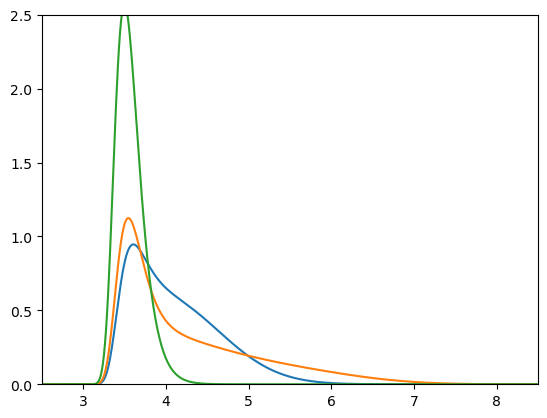

In [51]:
plt.plot(np.linspace(0,12,1001), signal_pdf1)
plt.plot(np.linspace(0,12,1001), signal_pdf2)
plt.plot(x,mf_background_pdf)

plt.ylim(0,2.5)
plt.xlim(2.5, 8.5)

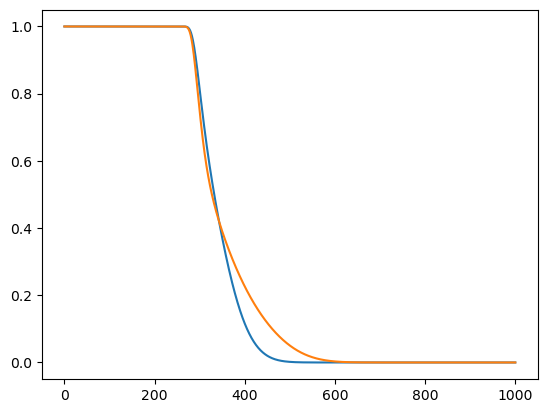

In [52]:
plt.plot(1-signal_cdf1)
plt.plot(1-signal_cdf2)

#plt.ylim(0,1.1)
#plt.xlim(35, 150)

(1e-06, 1)

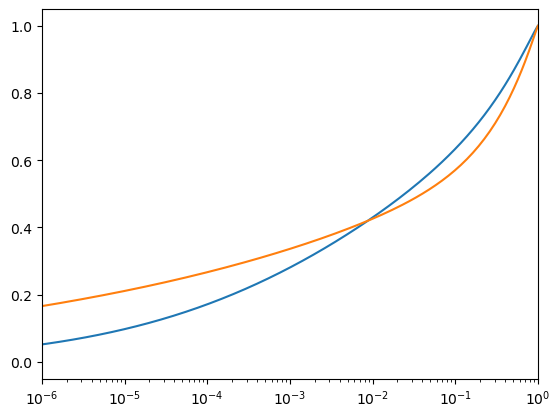

In [53]:
plt.plot(1-mf_background_cdf, 1-signal_cdf1)
plt.plot(1-mf_background_cdf, 1-signal_cdf2)
plt.xscale('log')
plt.xlim(1e-6, 1)

# minimum pitch angle

[[1.18e-08, 4.61e-08, 1.15e-08, 2.02e-08, ... 1.25e-08, 1.16e-08, 1.1e-08, 1.04e-08]]
5 / 9
91


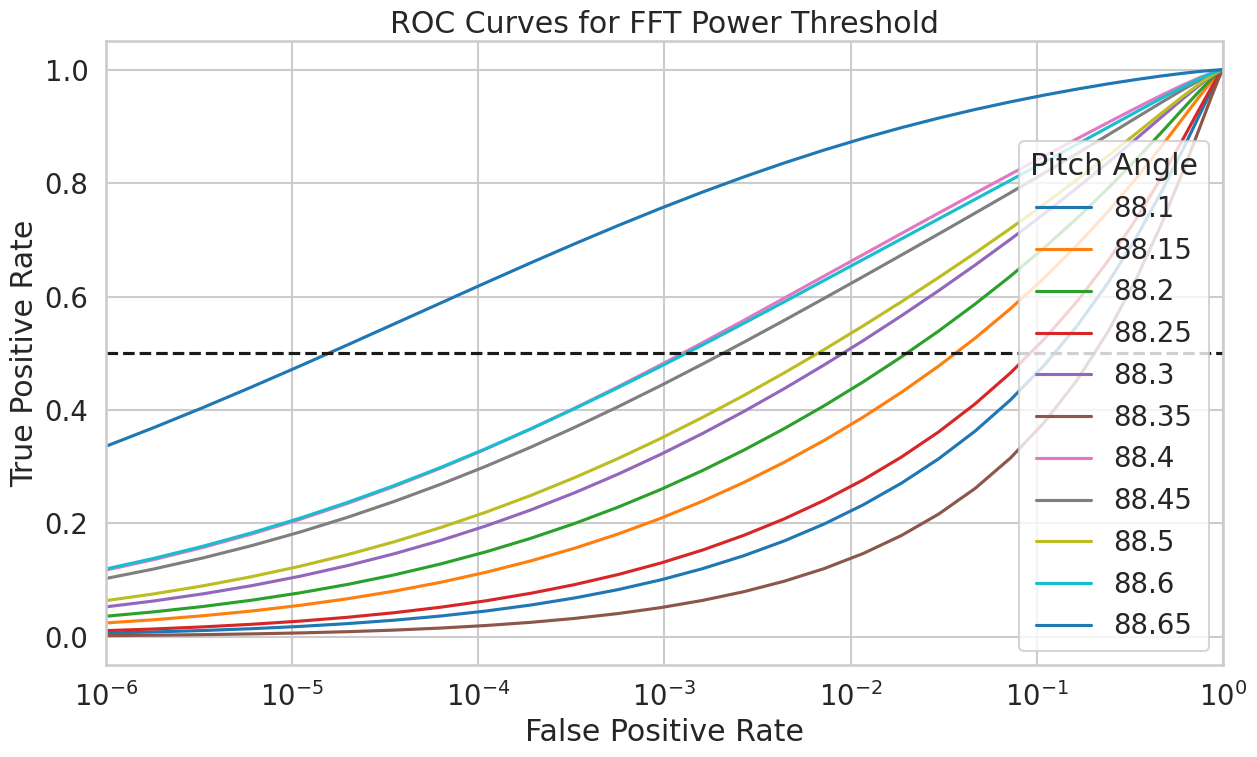

In [2]:

cdf, pdf, pitch, spectra = estimate_min_pitch()

#print(cdf.shape, pitch.shape)

#print(np.argsort(pitch))

#print(np.where(pitch==89.975))


#cdf = cdf[np.flip(np.argsort(pitch)), :]
#pdf = pdf[np.flip(np.argsort(pitch)), :]
#spectra = spectra[np.flip(np.argsort(pitch)), :]
#pitch = np.flip(np.sort(pitch))


print(pitch.size)

system_noise_temp = 10
n_pts_dist = 151
n_sample = 8192
noise_variance = 1.38e-23 * 50 * 60 * 205e6 * system_noise_temp / n_sample
x = np.linspace(0, 1e-6, n_pts_dist)
cdf_background = background_cdf(x, n_sample, noise_variance)
pdf_background = np.gradient(cdf_background) / np.trapz(np.gradient(cdf_background), x)
clist = sns.color_palette('tab10', n_colors=11)

sns.set_theme(context='talk', style='whitegrid', font_scale=1.2)
fig = plt.figure(figsize=(13, 8))
ax = fig.add_subplot(1,1,1)
for i, n in enumerate([52,53,54,55,56,57,58,59,60,62,63,]):
    
    ax.plot(1-cdf_background, 1-cdf[n, :], label=f'{pitch[n]}',color=clist[i])
    
ax.hlines(0.5, 1e-6, 1, color='k', ls='--')
ax.legend(loc=4, title='Pitch Angle')
ax.set_xscale('log')
ax.set_xlim(1e-6, 1)
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curves for FFT Power Threshold')
plt.tight_layout(pad=1.05)

#plt.savefig(
#    Path.home()/'group'/'project'/'plots'/'230208_fft_power_threshold_justification_for_max_pitch_angle',
#    dpi=144
#)

#sns.set_theme(context='talk', style='whitegrid', font_scale=1.2)
#fig = plt.figure(figsize=(13, 8))
#ax = fig.add_subplot(1,1,1)
#for i in range(0,9,1):
    
#    ax.plot(1-cdf_background, 1-cdf[i, :], label=f'{pitch[i]}')
    
#ax.legend(loc=4)
#ax.set_xscale('log')
#ax.set_xlim(1e-4, 1)

#sns.set_theme(context='talk', style='whitegrid', font_scale=1.2)
#fig = plt.figure(figsize=(13, 8))
#ax = fig.add_subplot(1,1,1)
#for i in [0, 90]:
    
#    ax.plot(abs(spectra[i]), label=f'{pitch[i]}')
    
#ax.legend(loc=4)
#ax.set_xscale('log')
#ax.set_xlim(1e-4, 1)

#print(np.argwhere(abs((1-cdf_background - 1e-2))<3e-3))


# Estimate FFT

In [3]:

system_noise_temp = 10
n_pts_dist = 151
n_sample = 8192
noise_variance = 1.38e-23 * 50 * 60 * 205e6 * system_noise_temp / n_sample
x = np.linspace(0, 1e-6, n_pts_dist)
min_pitch = 85.5
max_pitch = 88.5

fft_cdf_background = background_cdf(np.linspace(0, 1e-6, 1001), n_sample, noise_variance)
fft_pdf_background = np.gradient(fft_cdf_background) / np.trapz(np.gradient(fft_cdf_background), np.linspace(0, 1e-6, 1001))

fft_cdf_mean, fft_pdf_mean = estimate_mean_FFT(min_pitch=min_pitch, max_pitch=max_pitch, n_pts=n_pts_dist)

# build interpolator functions to make the plot nicer
x_interp = np.linspace(0, 1e-6, 501)
x_mean = np.linspace(0,1e-6, 151)
interp_mean = interpolate.interp1d(x_mean, fft_pdf_mean.mean(axis=0), kind='cubic')


# build interpolator functions to make the plot nicer
x_interp = np.linspace(0, 1e-6, 1001)
x_mean = np.linspace(0,1e-6, 151)
fft_interp_mean_cdf = interpolate.interp1d(x_mean, fft_cdf_mean.mean(axis=0), kind='cubic')




5 / 97
10 / 97
15 / 97
20 / 97
25 / 97
30 / 97
35 / 97
40 / 97
45 / 97
50 / 97
55 / 97
60 / 97
65 / 97
70 / 97
75 / 97
80 / 97
85 / 97
90 / 97
95 / 97


# visualize MF pdf's

[0. 0. 0. ... 0. 0. 0.]


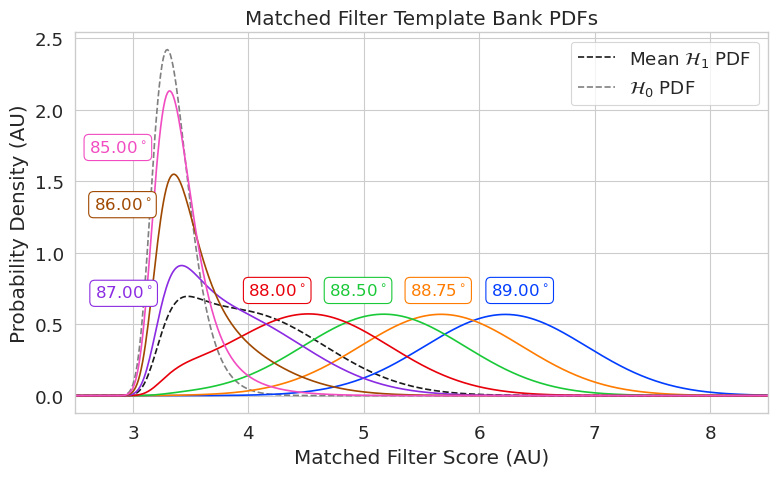

In [6]:
sns.set_theme(context='paper', style='whitegrid', font_scale=1.5)
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(1,1,1)
#clist = sns.color_palette('flare_r', n_colors=7)
clist = sns.color_palette('bright', n_colors=7)

x = np.linspace(0, 12, 1001)
mf_background_cdf = stats.rayleigh.cdf(x, loc=0, scale=(1/math.sqrt(2))) ** (1e5 / 2)
mf_background_pdf = np.gradient(mf_background_cdf)
mf_background_pdf = mf_background_pdf / np.trapz(mf_background_pdf, x)

mf_mean_cdf, mf_mean_pdf = get_mean_MF_distribution(n_pts=1001)
print(mf_mean_pdf)
line_back, = ax.plot(x, mf_background_pdf, color='grey',ls='--')

text_coords = [(6.1, 0.7), (5.4, 0.7), (4.7, 0.7), (4.0, 0.7), (2.67, 0.68), (2.66, 1.3), (2.62, 1.7)]

line_mean, = ax.plot(x, mf_mean_pdf, color='k', ls='--')
for i, pitch in enumerate([89, 88.75, 88.5, 88.0, 87.0, 86.0, 85.0]):
    temp_cdf, temp_pdf = get_MF_distribution(pitch, n_pts=1001)
    
    props = dict(boxstyle='round', facecolor='white', edgecolor=clist[i])
    ax.plot(
        x,
        temp_pdf,
        color=clist[i],
        label=rf'{pitch:.2f}$^\circ$'
    )
    ax.text(
        text_coords[i][0],
        text_coords[i][1],
        rf'{pitch:.2f}$^\circ$',
        color=clist[i],
        size=12,
        bbox=props,
    )
    
ax.set_xlim(2.5,8.5)
ax.set_xlabel('Matched Filter Score (AU)')
ax.set_ylabel('Probability Density (AU)')
ax.set_title(r'Matched Filter Template Bank PDFs')
plt.tight_layout(pad=1.05)
legend2 = plt.legend(
    [line_mean, line_back],
    [r'Mean $\mathcal{H}_1$ PDF', r'$\mathcal{H}_0$ PDF'],
    loc=1
)
#plt.legend(
#    loc=1,
#    title=r'$\mathcal{H}_1$ PDF'
#)
#plt.gca().add_artist(legend2)

plt.savefig(
    Path.home()/'group'/'project'/'plots'/'230913_mf_pdf_by_pitch',
    dpi=144,
)



# visualize mf cdf's

[0. 0. 0. ... 0. 0. 0.]


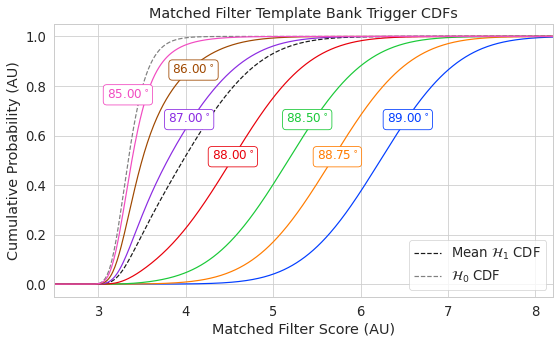

In [205]:
sns.set_theme(context='paper', style='whitegrid', font_scale=1.5)
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(1,1,1)
#clist = sns.color_palette('flare_r', n_colors=7)
clist = sns.color_palette('bright', n_colors=7)

x = np.linspace(0, 12, 1001)
mf_background_cdf = stats.rayleigh.cdf(x, loc=0, scale=(1/math.sqrt(2))) ** (1e5/2)
mf_background_pdf = np.gradient(mf_background_cdf)
mf_background_pdf = mf_background_pdf / np.trapz(mf_background_pdf, x)

mf_mean_cdf, mf_mean_pdf = get_mean_MF_distribution(n_pts=1001)
print(mf_mean_pdf)
line_back, = ax.plot(x, mf_background_cdf, color='grey',ls='--')


text_coords = [(6.3, 0.65), (5.5, 0.5), (5.15, 0.65), (4.3, 0.5), (3.8, 0.65), (3.85, 0.85), (3.1, 0.75)]
line_mean, = ax.plot(x,  mf_mean_cdf, color='k', ls='--')
for i, pitch in enumerate([89, 88.75, 88.5, 88.0, 87.0, 86.0,85.0]):
    temp_cdf, temp_pdf = get_MF_distribution(pitch, n_pts=1001)
    props = dict(boxstyle='round', facecolor='white', edgecolor=clist[i])
    ax.plot(
        x,
        temp_cdf,
        color=clist[i],
        label=f'{pitch:.2f}'+r'$^\circ$'
    )
    
    ax.text(
        text_coords[i][0],
        text_coords[i][1],
        rf'{pitch:.2f}$^\circ$',
        color=clist[i],
        size=12,
        bbox=props
    )
    
ax.set_xlim(2.5,8.2)
ax.set_xlabel('Matched Filter Score (AU)')
ax.set_ylabel('Cumulative Probability (AU)')
ax.set_title('Matched Filter Template Bank Trigger CDFs')
plt.tight_layout(pad=1.05)
legend2 = plt.legend(
    [line_mean, line_back],
    [r'Mean $\mathcal{H}_1$ CDF', r'$\mathcal{H}_0$ CDF'],
    loc=(4)
)
#plt.legend(
#    loc=5,
#    title='Signal CDF'+'\n'+'Pitch Angle'
#)
#plt.gca().add_artist(legend2)
plt.savefig(Path.home()/'group'/'project'/'plots'/'230314_mf_cdf_by_pitch', dpi=144)

# Estimate MF cdf as a function of match and number of templates

In [18]:
x = np.linspace(0, 12, 201)
N = 10000
noise_sf = 1 - stats.rayleigh.cdf(x, loc=0, scale=(1/math.sqrt(2))) ** (1)
noise_sf_sqrt_trial = 1 - stats.rayleigh.cdf(x, loc=0, scale=(1/math.sqrt(2))) ** (np.sqrt(N))
noise_sf_halfn_trial = 1 - stats.rayleigh.cdf(x, loc=0, scale=(1/math.sqrt(2))) ** (N/2)
noise_sf_logn_trial = 1 - stats.rayleigh.cdf(x, loc=0, scale=(1/math.sqrt(2))) ** (np.log(N))

#signal_sf = stats.rice.sf(x, score, loc=score*(1 - 1 / math.sqrt(2)), scale=1/math.sqrt(2))

mf_cdf_list = []
match_list = np.flip([0.5, 0.75, 0.83, 0.9, 0.95,])
N_template_list = np.flip([2800, 14500,23000, 43600, 93000,])
for i in range(len(match_list)):
    print(match_list[i])
    mf_cdf_list.append(estimate_MF_cdf_by_match(N_template_list[i], match=match_list[i]))

0.95
0.9
0.83
0.75
0.5


In [19]:
# background cdf will depend on the number of templates due to trials function
mf_background_cdf_list = []
for i in range(len(mf_cdf_list)):
    mf_background_cdf_list.append(
        stats.rayleigh.cdf(x, loc=0, scale=(1/math.sqrt(2))) ** (N_template_list[i]/1)
    )
    

(0.0, 0.25)

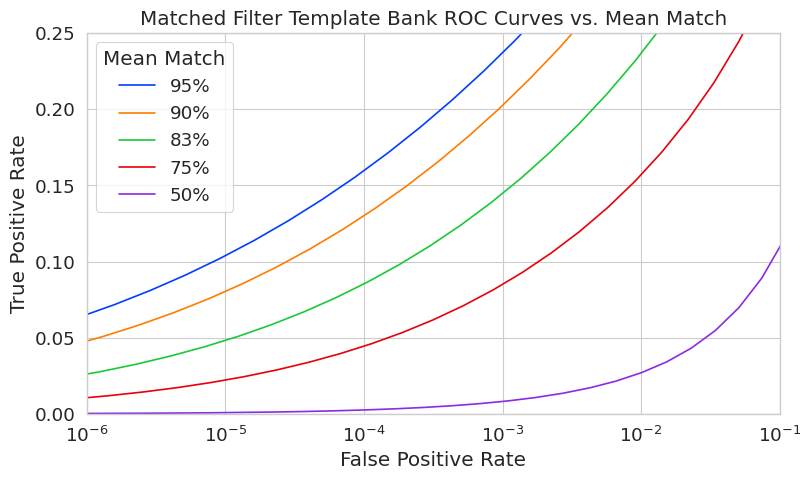

In [20]:
sns.set_theme(context='paper', style='whitegrid', font_scale=1.5)
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(1,1,1)
#clist = sns.color_palette('flare_r', n_colors=5)
clist = sns.color_palette('bright', n_colors=5)

text_coords = [(1.3e-4,0.18),(2.5e-5,0.1),(2e-4,0.12),(2e-3,0.11),(1e-2,0.03)]

for i in range(len(match_list)):
    auc = abs(np.trapz(1-mf_cdf_list[i].mean(axis=0), 1-mf_background_cdf_list[i]))
    props = dict(boxstyle='round', facecolor='white', edgecolor=clist[i])
    ax.plot(
        1-mf_background_cdf_list[i],
        1-mf_cdf_list[i].mean(axis=0),
        label=f'{np.int32(match_list[i]*100)}%',
        color=clist[i]
    )
    #ax.text(
    #    text_coords[i][0],
    #    text_coords[i][1],
    #    rf'{auc:.2f}',
    #    color=clist[i],
    #    size=12,
    #    bbox=props
    #)
    
    
#ax.plot(noise_sf_logn_trial, mf_sf_list[0].mean(axis=0), label='MF with log(n) Trial')
#ax.plot(noise_sf_sqrt_trial, mf_sf_list[0].mean(axis=0), label='MF with Sqrt(n) Trial')
#ax.plot(noise_sf_halfn_trial, mf_sf_list[0].mean(axis=0), label='MF with n/2 Trial')

#ax.plot(1-cdf_background, 1-cdf.mean(axis=0), label='FFT')
#auc = abs(np.trapz(1-cdf_mean.mean(axis=0), 1-cdf_background))
#ax.plot(1-cdf_background, 1-cdf_mean.mean(axis=0), color='k', label=f'FFT, AUC={round(auc, 2)}')
#ax.plot(np.linspace(0, 1, 1001), np.linspace(0,1,1001), ':', color='k')
ax.legend(loc=2, title='Mean Match')

ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Matched Filter Template Bank ROC Curves vs. Mean Match')
plt.tight_layout(pad=1.05)
ax.set_xscale('log')
ax.set_xlim(1e-6, 1e-1)
ax.set_ylim(0, 0.25)
#plt.savefig(Path.home()/'group'/'project'/'plots'/'230313_mf_average_roc_by_mean_match', dpi=144)

In [ ]:
mean_match, num_indicies = match_est_MF()



['scores', 'signal_ideal_scores', 'template_ideal_scores', 'signal_pitch', 'signal_energy', 'template_pitch', 'template_energy']
(41658, 252424) (41658,)
[   100    126    160    204    259    328    416    528    670    851
   1079   1369   1737   2204   2796   3548   4501   5710   7244   9190
  11659  14791  18764  23804  30199  38311  48603  61659  78222  99235
 125892]
1 / 31. Match = 0.10301767564680869, Templates = 100
2 / 31. Match = 0.11718596519340894, Templates = 126
3 / 31. Match = 0.13961963093400326, Templates = 160
4 / 31. Match = 0.16445414862101587, Templates = 204
5 / 31. Match = 0.18759307700937985, Templates = 259
6 / 31. Match = 0.22241509528297762, Templates = 328
7 / 31. Match = 0.2440690230732993, Templates = 416


NameError: name 'num_indicies' is not defined

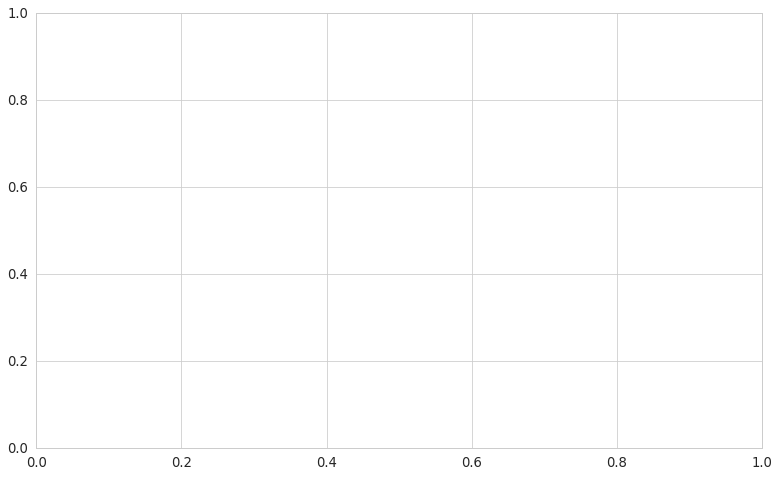

In [85]:
sns.set_theme(context='paper', style='whitegrid', font_scale=1.5)
cmap = sns.color_palette('turbo_r', 5)
clist = sns.color_palette('deep', 10)
fig = plt.figure(figsize=(13, 8))
ax = fig.add_subplot(1,1,1)

ax.plot(num_indicies, mean_match, '.')
ax.set_xlabel('Template Number (AU)')
ax.set_ylabel('Mean Match (AU)')
ax.set_title('Average Match vs Template Number')
ax.set_xscale('log')
ax.set_yscale('linear')
plt.tight_layout(pad=1.05)

#plt.savefig(Path.home()/'group'/'project'/'plots'/'230214_match_vs_template_number.png', dpi=144)

In [14]:
print(mean_match)




[0.1055033  0.12815414 0.16165785 0.20406744 0.24925691 0.2978864
 0.34617398 0.40070592 0.43840941 0.49793201 0.54334593 0.59317243
 0.64501263 0.69711973 0.74838208 0.79849552 0.8394777  0.88281831
 0.91351465 0.93903378 0.95941664]


# Estimate NN

In [6]:
labels, output, pitch = estimate_NN(n_epoch=100)
#nn2_fpr, nn2_tpr = estimate_NN2()




In [7]:
pitch




array([86.68787476, 87.33482185, 85.87470682, ...,  0.        ,
        0.        ,  0.        ])

In [8]:
nn_fpr_by_pitch = []
nn_tpr_by_pitch = []

for temp_pitch in [85.5]:#88.2, 88.1, 88.0, 87.9, 87.8, 87.7, 87.6, 87.5]:

    inds = ((pitch>=temp_pitch)*(pitch<=temp_pitch+3.0)+(pitch==0.0))
    nn_fpr_temp, nn_tpr_temp, _ = metrics.roc_curve(labels[inds], output[inds, 1])
    
    nn_fpr_by_pitch.append(nn_fpr_temp)
    nn_tpr_by_pitch.append(nn_tpr_temp)

nn_fpr_all, nn_tpr_all, _ = metrics.roc_curve(labels, output[:, 1])



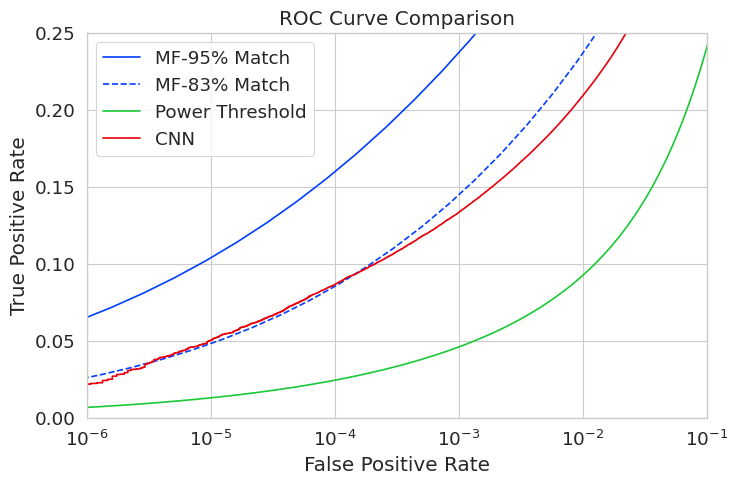

In [27]:
sns.set_theme(context='paper', style='whitegrid', font_scale=1.5)
#cmap = sns.color_palette('turbo', n_colors=5)
#clist = sns.color_palette('flare_r', n_colors=5)
clist = sns.color_palette('bright', n_colors=5)
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(1,1,1)


#ax.plot(nn_fpr_all, nn_tpr_all, label='NN')
x = np.linspace(0, 12, 201)

#ax.text(1.8e-2, 0.13, f'{auc_fft:.2f}', bbox=props, color=clist[2], size=12)

percent = [95, 0, 83]
ls = ['-', '', '--']
for i in [0,2]:# 1, 2, 3, 4]:
    noise_sf_mf = 1 - stats.rayleigh.cdf(x, loc=0, scale=(1/math.sqrt(2))) ** (N_template_list[i]/1)
    sf_mf = 1-mf_cdf_list[i].mean(axis=0)
    ax.plot(noise_sf_mf, sf_mf, color=clist[0], label=f'MF-{percent[i]}% Match', ls=ls[i])
    mf_auc = abs(np.trapz(sf_mf, noise_sf_mf))
    
props = dict(boxstyle='round', facecolor='white', edgecolor=clist[0])
#ax.text(0.9e-5, 0.11, f'{mf_auc:.2f}', bbox=props, color=clist[0], size=12)


#ax.plot(1-cdf_background, 1-cdf_mean.mean(axis=0), color='k', label='FFT')

auc_fft = abs(np.trapz(1-fft_interp_mean_cdf(x_interp),1-fft_cdf_background))
line_fft_mean, = ax.plot(1-fft_cdf_background, 1-fft_interp_mean_cdf(x_interp), ls='-', color=clist[2], label='Power Threshold')
props = dict(boxstyle='round', facecolor='white', edgecolor=clist[2])

auc_nn = abs(np.trapz(nn_tpr_by_pitch[0],nn_fpr_by_pitch[0],))
nn_line, = ax.plot(nn_fpr_by_pitch[0], nn_tpr_by_pitch[0], color=clist[3],label='CNN')
props = dict(boxstyle='round', facecolor='white', edgecolor=clist[3])
#ax.text(0.6e-3, 0.12, f'{auc_nn:.2f}', bbox=props, color=clist[3], size=12)

#ax.plot(nn_fpr_all, nn_tpr_all, label='NN', color='k',) 
    
leg1 = plt.legend(loc=2,)
#leg2 = plt.legend([nn_line, line_fft_mean], ['CNN', 'Power Threshold'], loc=(0.013, 0.4), title='')
#plt.gca().add_artist(leg1)
ax.set_xscale('log')
ax.set_xlim(1e-6, 1e-1)
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title(
    'ROC Curve Comparison'
)
ax.set_ylim(0,0.25)

plt.savefig(Path.home()/'group'/'project'/'plots'/'230327_nn_roc_vs_mf_vs_fft', dpi=150)

# Compare MF to NN to FFT

In [ ]:
sns.set_theme(context='talk', style='whitegrid', font_scale=1.2)
cmap = sns.color_palette('turbo_r', 5)
clist = sns.color_palette('deep', 10)
fig = plt.figure(figsize=(13, 8))
ax = fig.add_subplot(1,1,1)


for i, sf in enumerate(mf_sf_list): 
    ax.plot(noise_sf, mf_sf_list[i].mean(axis=0), color=cmap[i], lw=3,
            label=f'Match={np.round(match_list[i],1)}')
    
#ax.plot(noise_sf, best_sf.mean(axis=0), color='k')
ax.plot(nn_fpr, nn_tpr, color='k', lw=4, label='NN')
ax.plot(1-cdf_background, 1-cdf.mean(axis=0), ':', color='k', lw=4, label='FFT')
ax.plot(np.linspace(0, 1, 10001), np.linspace(0, 1, 10001), color='grey', label='Random')

ax.legend(loc=2)
ax.set_xscale('log')
ax.set_xlim(1e-4, 1)

ax.set_title('ROC Curve Comparison')
ax.set_ylabel('True Positive Rate')
ax.set_xlabel('False Positive Rate')

#plt.savefig(Path.home()/'group'/'project'/'plots'/'220822_roc_curve_comparison.png', dpi=128)

In [ ]:
1-cdf.mean(axis=0)[0:86]

In [ ]:
f_interp = interpolate.interp1d(nn_fpr, nn_tpr)

sns.set_theme(context='talk', style='whitegrid', font_scale=1.2)
cmap = sns.color_palette('inferno', 5)
clist = sns.color_palette('deep', 10)
fig = plt.figure(figsize=(13, 8))
ax = fig.add_subplot(1,1,1)

ax.plot(1-cdf_background[0:86], f_interp(1-cdf_background[0:86]) / (1-cdf.mean(axis=0)[0:86]), lw=4)
ax.set_xscale('log')
ax.set_xlim(1e-4, 1)
#ax.set_yscale('log')
ax.set_ylim(0, 12)

ax.set_title('True Positive Rate Ratio')
ax.set_xlabel('FPR')
ax.set_ylabel(r'$\mathrm{TPR}_{\mathrm{NN}}\:/\;\mathrm{TPR}_{\mathrm{FFT}}$')

#plt.savefig(Path.home()/'group'/'project'/'plots'/'220822_tpr_ratio.png', dpi=128)


In [ ]:
plt.plot(mean_match)

# Validation

In [ ]:
test_index = 1000
n_mc = 10000
noise = np.random.multivariate_normal([0, 0], np.eye(2) * noise_variance / 2, n_sample)
noise = noise[:, 0] + 1j * noise[:, 1]

sns.set_theme(context='talk', style='whitegrid', palette='bright')

fig = plt.figure(figsize=(13, 8))
ax = fig.add_subplot(1,1,1)
ax.plot(x, cdf[test_index, :])
ylims = ax.get_ylim()

fig = plt.figure(figsize=(13, 8))
ax = fig.add_subplot(1,1,1)
ax.plot(x, np.gradient(cdf[test_index, :]) / np.trapz(np.gradient(cdf[test_index, :]), x))
ylims = ax.get_ylim()

fig = plt.figure(figsize=(13, 8))
ax = fig.add_subplot(1,1,1)
ax.plot(abs(noise))
ax.plot(abs(signal_freq_spectra[test_index, :]))

test_peak_inds = np.where(abs(signal_freq_spectra[test_index, :])>peak_threshold)[0]
test_max_val = np.zeros(n_mc)

noise_only_max_val = np.zeros(n_mc)
for i in range(n_mc):
    
    noise = np.random.multivariate_normal([0, 0], np.eye(2) * noise_variance / 2, n_sample)
    noise = noise[:, 0] + 1j * noise[:, 1]
    
    test_max_val[i] = np.max(abs(noise + signal_freq_spectra[test_index, :])[:])
    
for i in range(n_mc):
    
    noise = np.random.multivariate_normal([0, 0], np.eye(2) * noise_variance / 2, n_sample)
    noise = noise[:, 0] + 1j * noise[:, 1]
    
    noise_only_max_val[i] = np.max(abs(noise))
    
fig = plt.figure(figsize=(13, 8))
ax = fig.add_subplot(1,1,1)
hist = ax.hist(test_max_val, 201, density=True, histtype='step')
hist = ax.hist(noise_only_max_val, 201, density=True, histtype='step')
ax.plot(x, np.gradient(cdf[test_index, :]) / np.trapz(np.gradient(cdf[test_index, :]), x))
ax.set_yscale('log')
#ax.set_ylim(1e3, 1e7)
  
    

In [ ]:
y_cdf.shape

In [ ]:
test_peaks_per_signal = ak.num(test_signal_peaks)

cdf_ak = []
count = 0
for n_peaks in test_peaks_per_signal:
    cdf_ak.append(y_cdf[count:count+n_peaks, :])
    count += n_peaks
cdf_ak = ak.Array(cdf_ak)



In [ ]:
ak.prod(cdf_ak, axis=1)

In [ ]:
np.prod(y_cdf[0:peaks_per_signal[0], :], axis=0).shape

In [ ]:
np.array_split(np.linspace(0, 100), 10)

In [ ]:
x = ak.Array([1,1,1,11,1,1,1,1,1,1,1,1])

In [ ]:
np.array_split(x, 3)